In [1]:
import re
import ast
import numpy as np
import os
from glob import glob

def extract_and_calculate_top5_accuracy(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        log_content = file.read()
    
    # 使用正则表达式匹配所有类似字典的结构
    pattern = r"\{'eval_loss': [^}]+'epoch': [^}]+\}"
    matches = re.findall(pattern, log_content)
    
    # 解析字符串为字典并收集所有eval_accuracy值
    accuracies = []
    for match in matches:
        try:
            # 安全地将字符串转换为字典
            data = ast.literal_eval(match)
            if 'eval_accuracy' in data:
                accuracies.append(data['eval_accuracy'])
        except (SyntaxError, ValueError):
            # 跳过格式不正确的条目
            continue
    
    # 检查是否找到足够的数据
    if len(accuracies) < 5:
        print(f"警告：只找到 {len(accuracies)} 个有效数据点，需要至少5个")
        return None
    
    # 获取最高的5个eval_accuracy值
    top5 = sorted(accuracies, reverse=True)[:5]
    
    # 计算均值
    average = sum(top5) / len(top5)
    
    return average

results, exp_names = [], []
log_files = glob(os.path.join("./train_logs", "*.txt"))
for log_file in log_files:
    exp_name = os.path.basename(log_file).split('.')[0]
    exp_names.append(exp_name)
    result = extract_and_calculate_top5_accuracy(log_file)
    results.append(result)
print("\n===== 批量处理结果 =====")
for name,res in zip(exp_names, results):
    print(f"{name}: {res}")


警告：只找到 4 个有效数据点，需要至少5个

===== 批量处理结果 =====
KD-MultiLayers[1-6]: 0.8928899082568809
KD-TWeight-loss-mse-MultiLayers[1-3]-hp-cosine_descent training on sst2-epochs 7-2025_7_11 10_29_15: 0.8878440366972477
KD-TWeight-loss-mse-MultiLayers[1-3]-hp-cosine_growth training on sst2-epochs 7-2025_7_11 10_29_12: 0.8990825688073395
KD-TWeight-loss-mse-MultiLayers[1-3]-hp-cosine_vshape training on sst2-epochs 7-2025_7_11 10_29_09: 0.8908256880733945
KD-TWeight-loss-mse-MultiLayers[1-3]-hp-cosine_^shape training on sst2-epochs 7-2025_7_11 10_29_06: 0.8956422018348624
KD-TWeight-MultiLayers[1-6]-hp-cosine_descent training: 0.8587155963302753
KD-TWeight-MultiLayers[1-6]-hp-cosine_growth: 0.871559633027523
KD-TWeight-MultiLayers[1-6]-hp-cosine_vshape: 0.8655963302752294
KD-TWeight-MultiLayers[1-6]-hp-cosine_^shape: 0.8678899082568808
KD-TWeight-SST: 0.8931192660550458
KD-Zero-loss-mse-MultiLayers[1-3]-hp-cosine_descent training on sst2-epochs 7-2025_7_11 10_29_26: 0.8311926605504587
KD-Zero-loss-mse-Mu

In [8]:
import math

class HpCallback():
    """
    Dynamic ajustment proportion of distillation.
    - During warmup：alpha is large (student self-learning) 
    - After middle training stage：alpha is small, beta/gamma are large (learning from teacher)
    """
    def __init__(self, total_steps, warmup_ratio=0.1):
        self.total_steps = total_steps
        self.warmup_steps = int(total_steps * warmup_ratio)
        self.alpha = 1.0
        self.beta = 0.0
        self.gamma = 0.0

    def on_step_end(self, step):
        if step > self.total_steps:
            return

        progress = step / self.total_steps

        if step < self.warmup_steps:
            self.alpha = 1.0
            self.beta = 0.0
            self.gamma = 0.0
        else:
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (progress - self.warmup_steps / self.total_steps) / (1 - self.warmup_steps / self.total_steps)))

            self.alpha = max(0.2, cosine_decay) 
            self.beta = min(0.5, (1 - cosine_decay) * 0.5)  
            self.gamma = min(0.5, (1 - cosine_decay) * 0.5)
        return self.alpha, self.beta, self.gamma

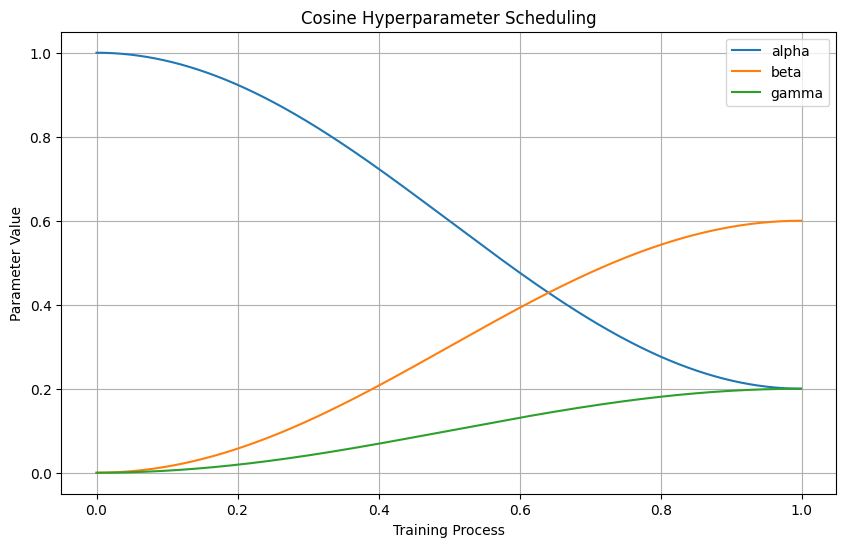

In [ ]:
import math
alpha = 0
def on_step_end(step):
    
    # 预热阶段：保持 alpha=0
    if step < 100:
        alpha = 0.0
    # 余弦增长阶段
    else:
        # 计算从预热结束后的进度 [0, 1]
        progress = (step - 100) / self.non_warmup_steps
        # 应用余弦曲线：从0到π/2（从0到1的单调递增）
        args.alpha = 1 - math.cos(progress * (math.pi / 2))

for p in processes:
    a, b, g = schedule_hyperparameters_cos(0.2, 0.6, 0.2, p)
    alphas.append(a)
    betas.append(b)
    gammas.append(g)

plt.figure(figsize=(10, 6))
plt.plot(processes, alphas, label='alpha')
plt.plot(processes, betas, label='beta')
plt.plot(processes, gammas, label='gamma')
plt.xlabel('Training Process')
plt.ylabel('Parameter Value')
plt.title('Cosine Hyperparameter Scheduling')
plt.legend()
plt.grid(True)
plt.show()

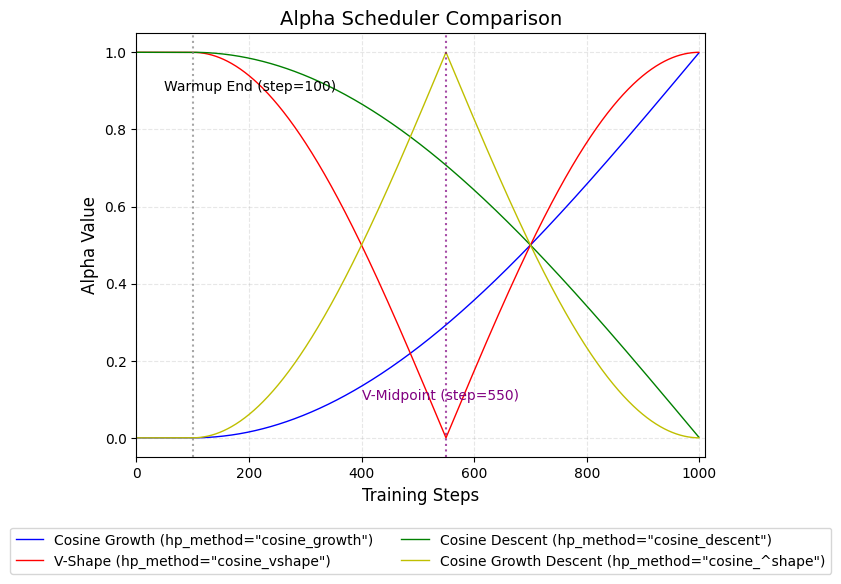

In [38]:
import math
from transformers import TrainerCallback

class UnifiedAlphaScheduler(TrainerCallback):
    """
    统一的超参数调度回调，支持两种调度方法：
    - 'cosine_growth': 余弦增长 (预热结束前alpha=0，之后从0→1)
    - 'cosine_vshape': V形余弦变化 (预热结束前alpha=1，之后从1→0→1)
    - 'cosine_descent': 余弦退火 (预热结束后alpha=1，之后从1→0)
    由 args.hp_method 参数控制
    """
    
    def __init__(self, total_steps, warmup_ratio=0.1):

        self.total_steps = total_steps
        self.warmup_steps = int(total_steps * warmup_ratio)
        self.non_warmup_steps = max(1, total_steps - self.warmup_steps)
        
        self.v_midpoint = self.warmup_steps + self.non_warmup_steps // 2
        self.v_descent_steps = max(1, self.v_midpoint - self.warmup_steps)
        self.v_ascent_steps = max(1, self.total_steps - self.v_midpoint)

    def on_step_end(self, args, state, control, **kwargs):
        step = state.global_step
        
        # 步数超过总量时停止计算
        if step > self.total_steps:
            return
            
        # scheduler_type = self.args.hp_method.lower()
        scheduler_type = getattr(args, 'hp_method', 'cosine_growth')
        assert scheduler_type in ['cosine_growth', 'cosine_vshape', 'cosine_descent', 'cosine_^shape'], \
            f'Unsupported scheduler type: {scheduler_type}'
        
        if scheduler_type == 'cosine_growth':
            self._cosine_growth_schedule(args, step)
        elif scheduler_type == 'cosine_vshape':
            self._vshape_schedule(args, step)
        elif scheduler_type == 'cosine_descent':
            self._cosine_descent_schedule(args, step)
        elif scheduler_type == 'cosine_^shape':
            self._cosine_growth_descent_schedule(args, step)

    
    def _cosine_growth_schedule(self, args, step):
        """alpha: 0->1"""
        if step <= self.warmup_steps:
            args.alpha = 0.0
        else:
            progress = (step - self.warmup_steps) / self.non_warmup_steps
            args.alpha = 1 - math.cos(progress * (math.pi / 2))
    
    def _vshape_schedule(self, args, step):
        """alpha: 1->0->1"""
        if step <= self.warmup_steps:
            args.alpha = 1.0
        elif step <= self.v_midpoint:
            progress = (step - self.warmup_steps) / self.v_descent_steps
            args.alpha = math.cos(progress * (math.pi / 2))
        else:
            progress = (step - self.v_midpoint) / self.v_ascent_steps
            args.alpha = math.sin(progress * (math.pi / 2))
    def _cosine_descent_schedule(self, args, step):
        """alpha: 0->1"""
        if step <= self.warmup_steps:
            args.alpha = 1.0
        else:
            progress = (step - self.warmup_steps) / self.non_warmup_steps
            args.alpha = math.cos(progress * (math.pi / 2))
    def _cosine_growth_descent_schedule(self, args, step):
        """alpha: 0->1->0"""
        if step <= self.warmup_steps:
            args.alpha = 0.0
        elif step <= self.v_midpoint:
            progress = (step - self.warmup_steps) / self.v_descent_steps
            args.alpha = 1 - math.cos(progress * (math.pi / 2))
        else:
            progress = (step - self.v_midpoint) / self.v_ascent_steps
            args.alpha = 1 - math.sin(progress * (math.pi / 2))
# 测试用例
if __name__ == "__main__":
    from types import SimpleNamespace
    from matplotlib import pyplot as plt
    import numpy as np
    
    # 测试两种调度方法
    total_steps = 1000
    warmup_ratio = 0.1
    
    # 余弦增长方法测试
    args_growth = SimpleNamespace(hp_method='cosine_growth')
    growth_callback = UnifiedAlphaScheduler(total_steps, warmup_ratio)
    
    # V形方法测试
    args_vshape = SimpleNamespace(hp_method='cosine_vshape')
    vshape_callback = UnifiedAlphaScheduler(total_steps, warmup_ratio)

    args_descent = SimpleNamespace(hp_method='cosine_descent')
    descent_callback = UnifiedAlphaScheduler(total_steps, warmup_ratio)

    args_gd = SimpleNamespace(hp_method='cosine_^shape')
    gd_callback = UnifiedAlphaScheduler(total_steps, warmup_ratio)
    
    # 模拟训练步数
    steps = np.arange(total_steps)
    alpha_growth = np.zeros(total_steps)
    alpha_vshape = np.zeros(total_steps)
    alpha_descent = np.zeros(total_steps)
    alpha_gd = np.zeros(total_steps)
    
    state = SimpleNamespace(global_step=0)
    control = None
    
    for step in range(total_steps):
        state.global_step = step
        
        # 计算余弦增长方法的alpha
        growth_callback.on_step_end(args_growth, state, control)
        alpha_growth[step] = args_growth.alpha
        
        # 计算V形方法的alpha
        vshape_callback.on_step_end(args_vshape, state, control)
        alpha_vshape[step] = args_vshape.alpha

        #
        descent_callback.on_step_end(args_descent, state, control)
        alpha_descent[step] = args_descent.alpha

        gd_callback.on_step_end(args_gd, state, control)
        alpha_gd[step] = args_gd.alpha

    
    # 绘制结果对比图
    plt.figure(figsize=(8, 6))
    
    # 余弦增长曲线
    plt.plot(steps, alpha_growth, 'b-', linewidth=1, 
             label='Cosine Growth (hp_method="cosine_growth")')
    
    # V形曲线
    plt.plot(steps, alpha_vshape, 'r-', linewidth=1, 
             label='V-Shape (hp_method="cosine_vshape")')
    
    plt.plot(steps, alpha_descent, 'g-', linewidth=1, 
             label='Cosine Descent (hp_method="cosine_descent")')
    
    plt.plot(steps, alpha_gd, 'y-', linewidth=1, 
             label='Cosine Growth Descent (hp_method="cosine_^shape")')
    
    # 标记关键点
    warmup_end = int(total_steps * warmup_ratio)
    v_midpoint = warmup_end + (total_steps - warmup_end) // 2
    
    plt.axvline(x=warmup_end, color='gray', linestyle=':', alpha=0.7)
    plt.axvline(x=v_midpoint, color='purple', linestyle=':', alpha=0.7)
    
    # 图表装饰
    plt.title('Alpha Scheduler Comparison', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Alpha Value', fontsize=12)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 设置坐标轴范围
    plt.xlim(0, total_steps * 1.01)
    plt.ylim(-0.05, 1.05)
    
    # 添加文本说明
    plt.text(50, 0.9, f'Warmup End (step={warmup_end})', fontsize=10)
    plt.text(v_midpoint-150, 0.1, f'V-Midpoint (step={v_midpoint})', fontsize=10, color='purple')
    
    plt.tight_layout()
    plt.savefig('alpha_schedule_comparison.png')
    plt.show()
